In [1]:
!pip install transformers[torch]
!pip install sentencepiece
!pip install datasets
!pip install evaluate

  Obtaining dependency information for accelerate>=0.20.3 from https://files.pythonhosted.org/packages/70/f9/c381bcdd0c3829d723aa14eec8e75c6c377b4ca61ec68b8093d9f35fc7a7/accelerate-0.21.0-py3-none-any.whl.metadata
  Using cached accelerate-0.21.0-py3-none-any.whl.metadata (17 kB)
Using cached accelerate-0.21.0-py3-none-any.whl (244 kB)
  Using cached sentencepiece-0.1.99-cp310-cp310-win_amd64.whl (977 kB)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import random
import tabulate
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# datasets
from datasets import Dataset
from datasets import DatasetDict
from datasets import load_metric
from datasets import load_dataset

# transformers
from transformers import Trainer
from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
from transformers import IntervalStrategy

import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.metrics import accuracy_score, f1_score

import evaluate

In [2]:
train_path = "train.csv"
test_path = "test.csv"
valid_path = "valid.csv"

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
valid_df = pd.read_csv(valid_path)

In [24]:
test_translated_df = pd.read_csv("./amazon_translated_body_and_title_with_originals.csv")

In [5]:
train_df = train_df[train_df["stars"].isin([1, 2, 4, 5])]
# train_df = train_df[train_df['language'].isin(['en', 'de', 'fr', 'es'])]
train_df = train_df[train_df["language"].isin(["en"])]

test_df = test_df[test_df["stars"].isin([1, 2, 4, 5])]
# test_df = test_df[test_df['language'].isin(['en', 'de', 'fr', 'es'])]
test_df = test_df[test_df["language"].isin(["en"])]

valid_df = valid_df[valid_df["stars"].isin([1, 2, 4, 5])]
# test_df = test_df[test_df['language'].isin(['en', 'de', 'fr', 'es'])]
valid_df = valid_df[valid_df["language"].isin(["en"])]


columns_to_drop = ["review_id", "product_id", "reviewer_id", "product_category"]
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)
valid_df.drop(columns=columns_to_drop, inplace=True)

In [6]:
num_rows_to_delete = 35000

In [7]:
for lang in ["en"]:
    # for lang in ['en', 'de', 'es', 'fr']:
    for star in [1, 2, 4, 5]:
        print(f"Language: {lang}, Stars: {star}")
        print(
            f'Number of rows before: {len(train_df[(train_df["language"] == lang) & (train_df["stars"] == star)])}'
        )
        random_indices = np.random.choice(
            train_df[
                (train_df["language"] == lang) & (train_df["stars"] == star)
            ].index,
            num_rows_to_delete,
            replace=False,
        )
        train_df.drop(index=random_indices, inplace=True)
        print(
            f'Number of rows after: {len(train_df[(train_df["language"] == lang) & (train_df["stars"] == star)])}'
        )

Language: en, Stars: 1
Number of rows before: 40000
Number of rows after: 5000
Language: en, Stars: 2
Number of rows before: 40000
Number of rows after: 5000
Language: en, Stars: 4
Number of rows before: 40000
Number of rows after: 5000
Language: en, Stars: 5
Number of rows before: 40000
Number of rows after: 5000


In [8]:
def replace_mapping(df, label):
    for i, r in df.iterrows():
        if r[label] >= 4:
            df.loc[i, label] = 1
        else:
            df.loc[i, label] = 0

    return df

In [9]:
train_df = replace_mapping(train_df, "stars")
test_df = replace_mapping(test_df, "stars")
valid_df = replace_mapping(valid_df, "stars")

In [10]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [12]:
def prepare_truncation(data_df, tokenizer, m, n):
    # Create a tqdm progress bar for the loop
    for i, r in tqdm(data_df.iterrows(), total=len(data_df), desc="Processing reviews"):
        tokenized_row = tokenizer.tokenize(r["review_body"])
        if len(tokenized_row) > m + n:
            data_df.loc[i, "review_body"] = tokenizer.convert_tokens_to_string(
                tokenized_row[:m] + tokenized_row[-n:]
            )

    return data_df

In [28]:
# Preprocess function with labels
def preprocess_function(examples):
    inputs = tokenizer(examples["review_body"], truncation=True)
    inputs["labels"] = examples["stars"]
    return inputs

In [14]:
target_names = ["Negative", "Positive"]

In [15]:
def plotConfusionMatrix(title, confusionMat, targetNames):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.matshow(
        confusionMat, aspect="auto", vmin=0, vmax=1000, cmap=plt.get_cmap("Blues")
    )
    plt.ylabel("Predicted Category")
    plt.yticks(range(len(targetNames)), targetNames)
    plt.xlabel("Actual Category")
    plt.xticks(range(len(targetNames)), targetNames, rotation=90)
    plt.title(title)
    plt.show()

In [16]:
from tabulate import tabulate


def print_using_tabulate(data):
    table_data = []
    for key, values in data.items():
        if key != "macro avg" and key != "weighted avg":
            if isinstance(values, dict):
                row = [
                    key,
                    values["precision"],
                    values["recall"],
                    values["f1-score"],
                    values["support"],
                ]
                table_data.append(row)

    # Print the classification report using tabulate
    headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
    m_table = tabulate(table_data, headers=headers, tablefmt="psql", floatfmt=".4f")
    print(m_table)

In [20]:
exclude_models = [
    ".ipynb_checkpoints",
    "bert-base-uncased_5classes_128tokens_0.56f1",
    "bert-base-multilingual-cased_2classes_510tokens_0.89f1",
    "model_weights-title-84acc",
]

In [17]:
weights_path = "./weights"

In [18]:
import re
import os


def calc_m_and_n(file_name):
    # Search for the pattern '_\d+tokens' in the input_string
    match = re.search(r"_(\d+)token", file_name)
    extracted_value = None

    if match:
        extracted_value = match.group(1)
    else:
        print("No value found in the input string.")

    if extracted_value == 128:
        return 64, 64
    else:
        return 128, 382

In [24]:
print(os.listdir("./weights/"))
[
    "bert-base-cased_2classes_128tokens_0.92f1",
    "bert-base-cased_2classes_510tokens_0.91f1",
    "bert-base-multilingual-cased_2classes_510tokens_0.89f1",
    "bert-base-uncased_2classes_128tokens_0.92f1",
    "bert-base-uncased_2classes_510tokens_0.92f1",
    "bert-base-uncased_5classes_128tokens_0.56f1",
    "model_weights-title-84acc",
    "uncased-92acc-2classes-510tokens",
]

['bert-base-cased_2classes_128tokens_0.92f1', 'bert-base-cased_2classes_510tokens_0.91f1', 'bert-base-multilingual-cased_2classes_510tokens_0.89f1', 'bert-base-uncased_2classes_128tokens_0.92f1', 'bert-base-uncased_2classes_510tokens_0.92f1', 'bert-base-uncased_5classes_128tokens_0.56f1', 'model_weights-title-84acc', 'uncased-92acc-2classes-510tokens']


In [51]:
def eval_model(
    model, test_set, tokenizer, data_collator, compute_metrics, target_names, name
):
    trainer = Trainer(
        model=model,
        train_dataset=None,
        eval_dataset=None,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # trainer.evaluate(eval_dataset=test_set)
    predictions = trainer.predict(test_set)
    predicted_labels = predictions.predictions.argmax(axis=1)
    ground_truth_labels = test_set["stars"]
    cm = confusion_matrix(predicted_labels, ground_truth_labels)
    plotConfusionMatrix(f"Confusion Matrix: {name}", cm, target_names)
    classification_reports = classification_report(
        ground_truth_labels,
        predicted_labels,
        target_names=["negative", "positive"],
        output_dict=True,
    )
    print_using_tabulate(classification_reports)
    print("\n\n\n")

In [33]:
translated_body = test_translated_df.copy()

In [42]:
translated_body.head()

,Unnamed: 0,stars,language,translated_title,review_body
0,0,0,de,Unfortunately not recommended,"Unfortunately, unfortunately faded after one w..."
1,1,0,de,Rubber broken after 6 months,"first of all, the anchor holder makes a solid ..."
2,2,0,de,flea market goods,Seal and packaging was damaged and item was us...
3,3,0,de,catastrophe,NEVER received this product and the money was ...
4,4,0,de,Zipper is stuck,The straps ripped off quickly


In [39]:

columns_to_drop = ["review_body", "review_title"]
translated_body.drop(columns=columns_to_drop, inplace=True)

In [41]:
translated_body.rename(columns={'translated_body': 'review_body'}, inplace=True)

In [55]:
import json
tokenizer = None


def evaluate_model(f):
    # for f in os.listdir(weights_path):
    # if f in exclude_models:
    #     print(f"model excluded: {f}")
    #     continue
    model_name = None
    global tokenizer
    with open(os.path.join(weights_path, f, "config.json"), "r") as config:
        data = json.load(config)
        model_name = data["_name_or_path"]
        data = None

    print(f"Starting evaluation for {f}\n")
    tokenizer = AutoTokenizer.from_pretrained(model_name, num_labels=2)
    n, m = calc_m_and_n(f)
    print(f"Using N={n} and M={m}\n")
    # train = prepare_truncation(train_df, tokenizer, m, n)
    test = prepare_truncation(test_df, tokenizer, m, n)
    test_translated = prepare_truncation(translated_body, tokenizer, m, n)
    # valid = prepare_truncation(valid_df, tokenizer, m, n)
    # train_ds = Dataset.from_pandas(train)
    test_ds = Dataset.from_pandas(test)
    test_translated_ds = Dataset.from_pandas(test_translated)
    # valid_ds = Dataset.from_pandas(valid)

    en_only_dataset = DatasetDict()

    # en_only_dataset["train"] = train_ds
    # en_only_dataset["validation"] = valid_ds
    en_only_dataset["test"] = test_ds
    en_only_dataset["test_translated"] = test_translated_ds

    # # Tokenize the datasets
    # tokenized_train = en_only_dataset["train"].map(preprocess_function, batched=True)
    # tokenized_validation = en_only_dataset["validation"].map(
    #     preprocess_function, batched=True
    # )
    tokenized_test = en_only_dataset["test"].map(preprocess_function, batched=True)
    tokenized_test_translated = en_only_dataset["test_translated"].map(preprocess_function, batched=True)

    # Data collator for padding
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(
        os.path.join(weights_path, f)
    )

    # Load metrics outside the compute_metrics function
    load_accuracy = evaluate.load("accuracy")
    load_f1 = evaluate.load("f1")

    # Compute metrics function
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        accuracy = load_accuracy.compute(predictions=predictions, references=labels)[
            "accuracy"
        ]
        f1 = load_f1.compute(
            predictions=predictions, references=labels, average="weighted"
        )["f1"]
        return {"accuracy": accuracy, "f1": f1}

    print("Evaluation on English only dataset\n")
    eval_model(model, tokenized_test, tokenizer, data_collator, compute_metrics, target_names, name=f"{f} - English only dataset")
    print("Evaluation on translated dataset\n")
    eval_model(model, tokenized_test_translated, tokenizer, data_collator, compute_metrics, target_names, name=f"{f} - Translated dataset")

Starting evaluation for bert-base-cased_2classes_128tokens_0.92f1

Using N=128 and M=382



Processing reviews: 100%|██████████| 12000/12000 [00:02<00:00, 5010.82it/s]


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Evaluation on English only dataset



You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/500 [00:00<?, ?it/s]

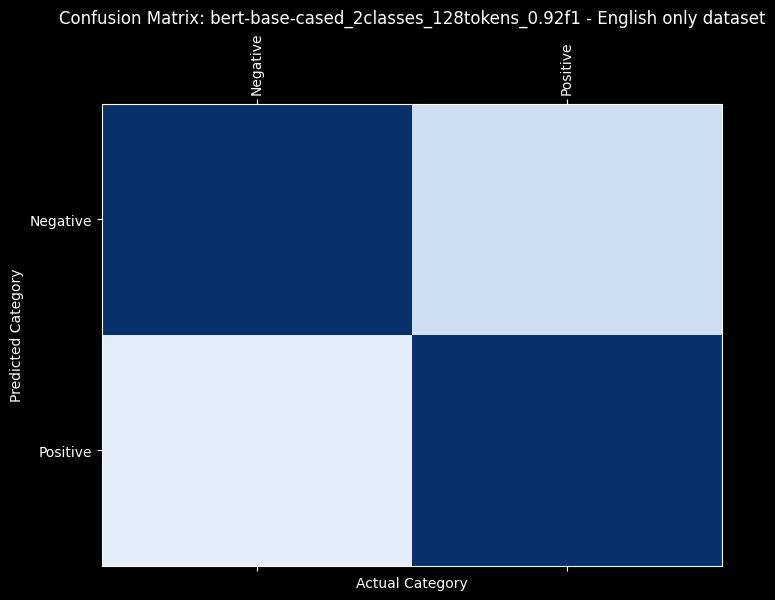

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
|----------+-------------+----------+------------+-----------|
| negative |      0.8999 |   0.9480 |     0.9233 | 2000.0000 |
| positive |      0.9451 |   0.8945 |     0.9191 | 2000.0000 |
+----------+-------------+----------+------------+-----------+




Evaluation on translated dataset



  0%|          | 0/1500 [00:00<?, ?it/s]

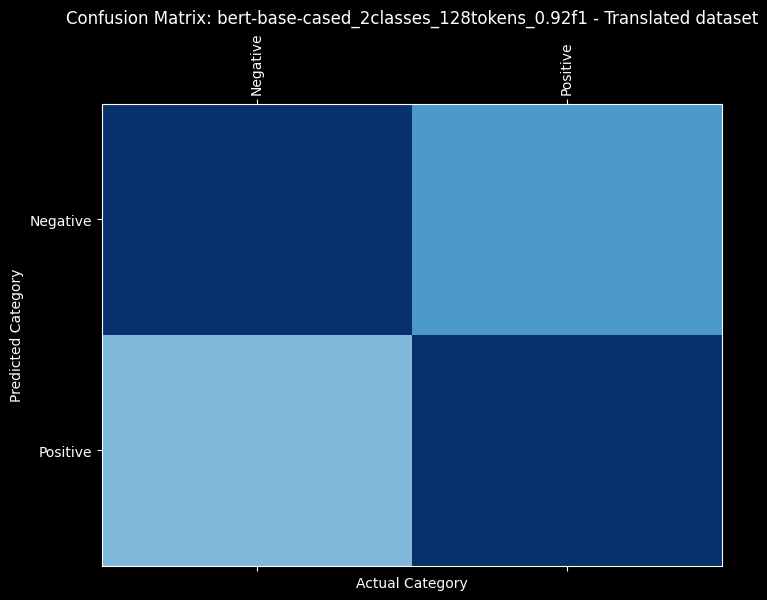

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
|----------+-------------+----------+------------+-----------|
| negative |      0.9028 |   0.9247 |     0.9136 | 6000.0000 |
| positive |      0.9228 |   0.9005 |     0.9115 | 6000.0000 |
+----------+-------------+----------+------------+-----------+






In [56]:
evaluate_model("bert-base-cased_2classes_128tokens_0.92f1")

Starting evaluation for bert-base-cased_2classes_510tokens_0.91f1

Using N=128 and M=382



Processing reviews: 100%|██████████| 12000/12000 [00:02<00:00, 5455.95it/s]


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Evaluation on English only dataset



You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/500 [00:00<?, ?it/s]

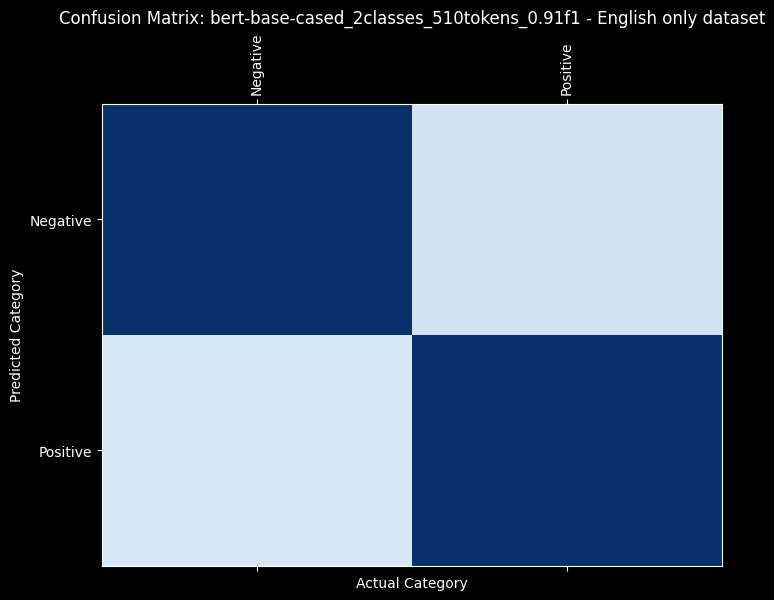

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
|----------+-------------+----------+------------+-----------|
| negative |      0.9073 |   0.9205 |     0.9139 | 2000.0000 |
| positive |      0.9193 |   0.9060 |     0.9126 | 2000.0000 |
+----------+-------------+----------+------------+-----------+




Evaluation on translated dataset



  0%|          | 0/1500 [00:00<?, ?it/s]

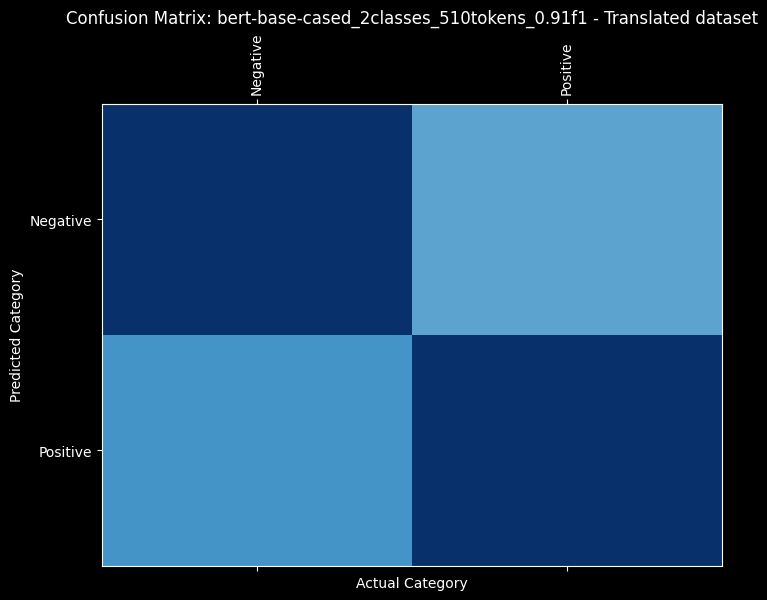

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
|----------+-------------+----------+------------+-----------|
| negative |      0.9079 |   0.8973 |     0.9026 | 6000.0000 |
| positive |      0.8985 |   0.9090 |     0.9037 | 6000.0000 |
+----------+-------------+----------+------------+-----------+






In [57]:
evaluate_model("bert-base-cased_2classes_510tokens_0.91f1")

Starting evaluation for bert-base-uncased_2classes_128tokens_0.92f1

Using N=128 and M=382



Processing reviews: 100%|██████████| 12000/12000 [00:02<00:00, 4701.35it/s]


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Evaluation on English only dataset



  0%|          | 0/500 [00:00<?, ?it/s]

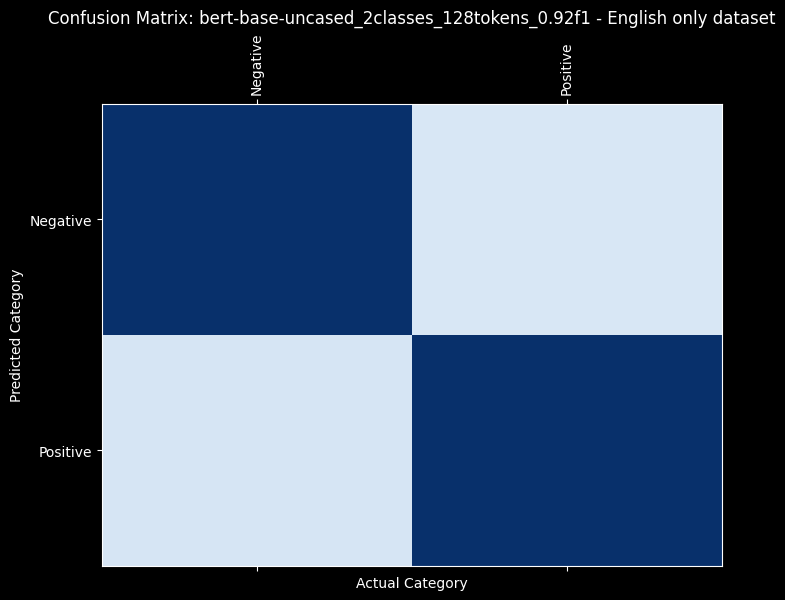

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
|----------+-------------+----------+------------+-----------|
| negative |      0.9230 |   0.9165 |     0.9197 | 2000.0000 |
| positive |      0.9171 |   0.9235 |     0.9203 | 2000.0000 |
+----------+-------------+----------+------------+-----------+




Evaluation on translated dataset



  0%|          | 0/1500 [00:00<?, ?it/s]

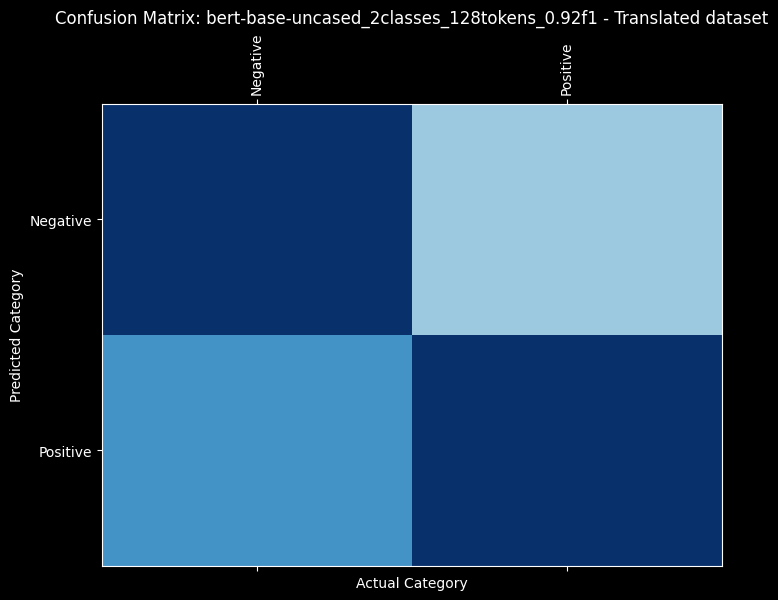

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
|----------+-------------+----------+------------+-----------|
| negative |      0.9349 |   0.8968 |     0.9154 | 6000.0000 |
| positive |      0.9009 |   0.9375 |     0.9188 | 6000.0000 |
+----------+-------------+----------+------------+-----------+






In [62]:
evaluate_model("bert-base-uncased_2classes_128tokens_0.92f1")

Starting evaluation for bert-base-multilingual-cased_2classes_510tokens_0.89f1

Using N=128 and M=382



Processing reviews: 100%|██████████| 12000/12000 [00:02<00:00, 4957.12it/s]


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Evaluation on English only dataset



You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/500 [00:00<?, ?it/s]

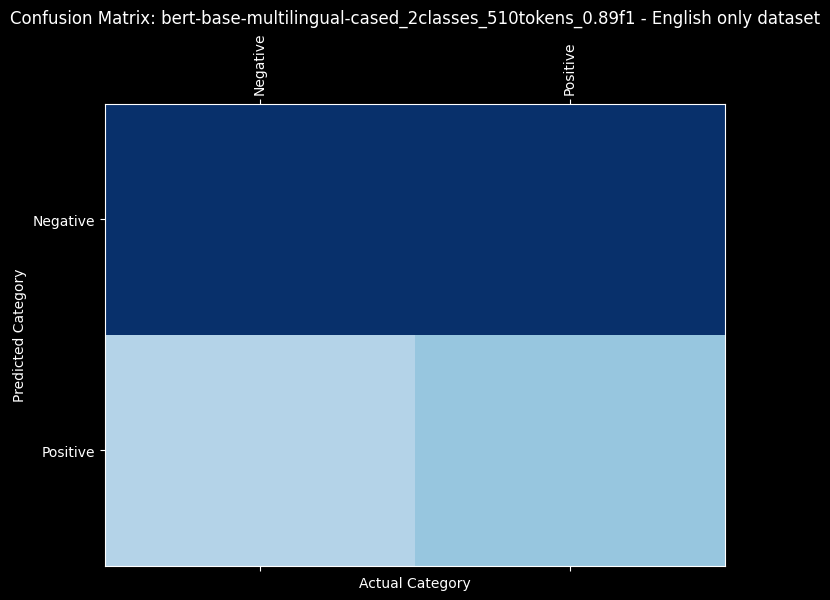

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
|----------+-------------+----------+------------+-----------|
| negative |      0.5132 |   0.8475 |     0.6393 | 2000.0000 |
| positive |      0.5624 |   0.1960 |     0.2907 | 2000.0000 |
+----------+-------------+----------+------------+-----------+




Evaluation on translated dataset



  0%|          | 0/1500 [00:00<?, ?it/s]

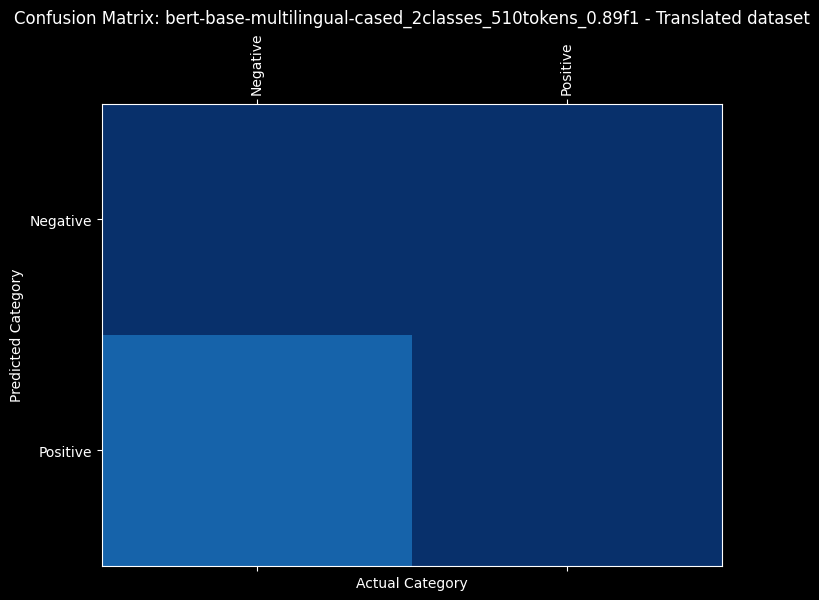

+----------+-------------+----------+------------+-----------+
| Class    |   Precision |   Recall |   F1-Score |   Support |
|----------+-------------+----------+------------+-----------|
| negative |      0.5243 |   0.8665 |     0.6533 | 6000.0000 |
| positive |      0.6155 |   0.2137 |     0.3172 | 6000.0000 |
+----------+-------------+----------+------------+-----------+






In [63]:
evaluate_model("bert-base-multilingual-cased_2classes_510tokens_0.89f1")